In [14]:
# !python -m spacy download en_core_web_sm

In [15]:
#Others required libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import nltk
import spacy
import re
import emoji
import pickle
import string
from joblib import dump, load

In [16]:
training_headline_df = pd.read_csv('../input/reddit-fin-headlines-data/2k_new_labelled.csv')[['sentiment', 'title']]
serving_headline_df = pd.read_csv('../input/reddit-fin-headlines-data/8k-labelled-vader.csv')[['sentiment','title']]

kaggle_headline_df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', sep=',', encoding='latin-1',names = ["sentiment","title"])
combined_df = pd.concat([training_headline_df, kaggle_headline_df]).sample(frac=1)

# Machine Learning

In [17]:
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

from joblib import load

In [18]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Function to remove @names and special character
def punc_clean(text):
    text= ' '.join(re.sub('(@[A-Za-z0-9_]+)|(&[A-Za-z0-9_]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)|(["“)#!?”(-.%&$,*/;:<>=\/|^`{}~])' , " ", text).split())
    text = re.sub('[0-9]+', '', text)
    text = re.sub('['+string.punctuation+']', '', text)
    return text


def space(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def preprocess(data):
    data['title'] = data['title'].apply(lambda x: x.lower())
    data['title'] = data['title'].apply(lambda x: emoji.demojize(x))
    data['title'] = data['title'].str.encode('ascii', 'ignore').str.decode('ascii')
    data['title'] = data['title'].apply(space)
    data['title'] = data['title'].apply(punc_clean)

    has_duplicate = data.duplicated(subset = ['title']).any()
    if has_duplicate:
        data.drop_duplicates(subset = ['title'], inplace = True)
    return data

In [20]:
def vectorize(data, tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [21]:
def preprocess_data(df, model_name):
    df = preprocess(df)

    X_data = df[['title']].to_numpy().reshape(-1)
    Y_data = df[['sentiment']].to_numpy().reshape(-1)

    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.1, random_state = 1)
    
    tfidf_vect = TfidfVectorizer(analyzer = 'word')
    tfidf_vect_fit = tfidf_vect.fit(X_train)
    X_train = vectorize(X_train, tfidf_vect_fit)
    
    with open(f'tfidf_{model_name}.pickle', 'wb') as write_file:
        pickle.dump(tfidf_vect_fit, write_file, protocol = pickle.HIGHEST_PROTOCOL)
    
    return X_train, X_test, Y_train, Y_test, tfidf_vect_fit

In [22]:
def create_model(pretrain_weight = None):
    if pretrain_weight:
        clf2 =  load(pretrain_weight)
    else:
        rfClf = RandomForestClassifier(n_estimators = 200) # 200 trees. 
        svmClf = SVC(probability = True, random_state = 1) # probability calculation
        logClf = LogisticRegression(random_state = 1, max_iter = 200)
        adaboostClf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100)

        clf2 = VotingClassifier(estimators = [('rf', rfClf), ('svm', svmClf), ('log', logClf)], voting = 'soft')

    return clf2

In [23]:
def training(model_name, clf2):
    # Train the ensemble classifier
    clf2.fit(X_train, Y_train)
    dump(clf2, f"{model_name}.joblib")
    return clf2

In [24]:
def evaluate_metric(clf2, X_test, Y_test, tfidf_vect_fit):
    X_test = vectorize(X_test, tfidf_vect_fit)
    Y_pred = clf2.predict(X_test)

    print(classification_report(Y_test, Y_pred))
    print(accuracy_score(Y_test, Y_pred))
    
    ConfusionMatrixDisplay.from_predictions(
            Y_test,
            Y_pred,
            normalize = 'all'
        )

---------------------------------------------------
Start training for train_on_kg
Shape of training set:  (4315, 7099) (4315,)
Shape of test set:  (480,) (480,)
---------------------------------------------------
Result Metric
              precision    recall  f1-score   support

    negative       0.89      0.61      0.72        66
     neutral       0.76      0.96      0.85       272
    positive       0.88      0.58      0.70       142

    accuracy                           0.80       480
   macro avg       0.84      0.72      0.76       480
weighted avg       0.82      0.80      0.79       480

0.7979166666666667
Finish train_on_kg
---------------------------------------------------
---------------------------------------------------
Start training for train_on_reddit
Shape of training set:  (1841, 4089) (1841,)
Shape of test set:  (205,) (205,)
---------------------------------------------------
Result Metric
              precision    recall  f1-score   support

    negative  

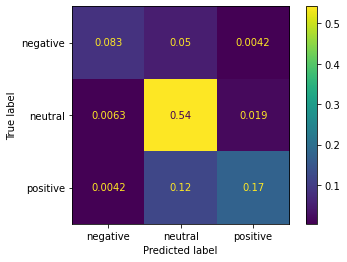

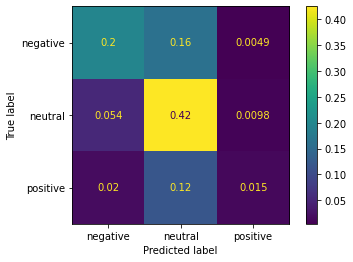

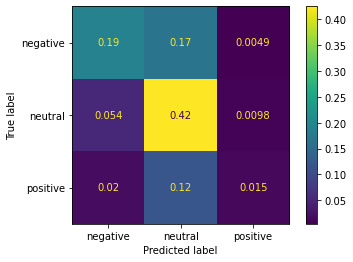

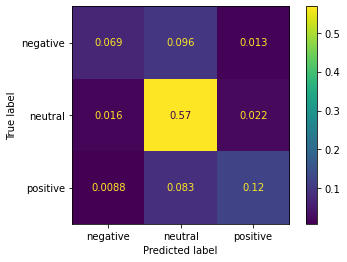

In [25]:
model_data = {
    "train_on_kg": kaggle_headline_df,
    "train_on_reddit": training_headline_df,
    "transfer_learning_on_reddit": training_headline_df,
    "combined_data": combined_df 
}

for model_name in model_data:
    print("---------------------------------------------------")
    print(f"Start training for {model_name}")
    df = model_data[model_name]
    X_train, X_test, Y_train, Y_test, tfidf_vect_fit = preprocess_data(df, model_name)
    print("Shape of training set: ", X_train.shape, Y_train.shape)
    print("Shape of test set: ", X_test.shape, Y_test.shape)
    if model_name == "transfer_learning_on_reddit":
        pretrained = 'train_on_kg.joblib'
    else:
        pretrained = None
    clf2 = create_model(pretrained)
    clf2 = training(model_name, clf2)
    print("---------------------------------------------------")
    print("Result Metric")
    evaluate_metric(clf2, X_test, Y_test, tfidf_vect_fit)
    print(f"Finish {model_name}")
    print("---------------------------------------------------")